In [12]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset_test import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [13]:
# Overall settings
out_dir = "out"
batch_size = 1024

model_name = "ckpt_zerostep_sim_matlab_50pct_real_val_alt_h50.pt"
# folder_path = '../data/CL_experiments/test/inertia07_ki-0.0061-kp-11.8427'
# folder_path = '../data/CL_experiments/test/inertia04_ki-0.0061-kp-11.8427'
# folder_path = '../data/simulated/10_percent'
# folder_path = '../data/simulated/50_percent_longer_steps'
folder_path = '../data/CL_experiments/train/inertia13_ki-0.0061-kp-11.8427'

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())

True


In [14]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/model_name, map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])

50
1374


In [15]:
# Expected rmse speed
# np.sqrt(exp_data['best_val_loss']) * 2500

In [16]:
# exp_data.keys()

number of parameters: 0.03M


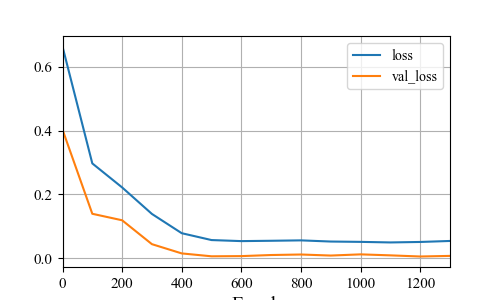

Model size in KB: 100.56640625


In [17]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

plt.figure(figsize=(5,3))
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS'][::100], label="loss")
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS_VAL'][::100], label="val_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

size_in_bytes = sum(param.numel() * param.element_size() for param in model.parameters())
size_in_bytes += sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())

# Convert bytes to kilobytes
size_in_kb = size_in_bytes / 1024
print('Model size in KB:', size_in_kb)

In [29]:
dfs = load_dataframes_from_folder(folder_path)
# Log the number of DataFrames loaded
print(f"Loaded {len(dfs)} DataFrames from {folder_path}.") 

# Create an instance of the dataset
dataset_exp = Dataset(dfs=dfs, seq_len=1000)
dataloader = DataLoader(dataset_exp, batch_size=batch_size, shuffle=True)

# df_idx = np.random.choice(len(dfs))
# df = dfs[df_idx]
# diff_array = df['r'].diff(-seq_len).to_numpy()
# diff_array = diff_array[~np.isnan(diff_array)]
# prob_ratio = 0.5 # ratio between constant samples and step samples
# if np.random.rand() >= prob_ratio:
#     good_idx = np.flatnonzero(diff_array == 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array != 0)
# else:
#     good_idx = np.flatnonzero(diff_array != 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array == 0)
# start_idx = np.random.choice(good_idx)
# batch_y = torch.tensor(df['omega'].iloc[start_idx:start_idx + seq_len].values, dtype=torch.float32)
# print(batch_y)


# Example of accessing an item
batch_u, batch_y = next(iter(dataloader))
batch_u, batch_y = batch_u.to(device), batch_y.to(device)
batch_y_pred = torch.empty_like(batch_y)
cputime = np.empty(batch_y.shape[1])

b, tt, _ = batch_y.shape 
print(b, tt)

Loaded 100 DataFrames from ../data/CL_experiments/train/inertia13_ki-0.0061-kp-11.8427.
512 1000


In [19]:
H = exp_data["cfg"].seq_len

# with torch.no_grad():
    
#     for i in range(tt):
        
#         print('time instant:', i)

#         # Controller u(t) = C(e(t),u(t-1))
#         start = time.time()
#         if i < H:
#             pred = model(batch_u[:, :i+1, :])
#         else:
#             pred = model(batch_u[:, i-H+1:i+1, :])
        
#         cputime[i] = time.time() - start
#         batch_y_pred[:,i,0] = pred[:,-1,0]
#         print(cputime[i])

# print(np.mean(cputime))
        
# # Reverse norm
# batch_u, batch_y, batch_y_pred = reverse_normalization(batch_u, batch_y, batch_y_pred)

In [20]:
# # Convert batch tensors to numpy for plotting
# batch_y_np = batch_y.cpu().numpy()  # Shape (seq_len, 1)
# batch_y_pred_np = batch_y_pred.cpu().numpy()  # Shape (seq_len, 1)

# # Plotting
# fig, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

# # Plotting in each subplot
# for i in range(4):
#     axes[i].plot(batch_y_np[i], label=r"$\omega$", color="tab:green")
#     axes[i].plot(batch_y_pred_np[i], label=r"$\hat{\omega}$", color="tab:purple", linestyle="--")
#     axes[i].set_ylim([-1000, 3000])
# axes[0].legend(bbox_to_anchor=(0.7, 1.65), ncols=2)

# mean_error = (batch_y_np - batch_y_pred_np).mean(axis=0).flatten()
# std_error = (batch_y_np - batch_y_pred_np).std(axis=0).flatten()
# mse = ((batch_y_np - batch_y_pred_np)**2).mean(axis=0).flatten()

# axes[-1].plot(mean_error, label="$e$", color="tab:red")
# axes[-1].fill_between(
#     np.arange(mean_error.shape[0]), 
#     mean_error + std_error, 
#     mean_error - std_error, 
#     color='tab:red', 
#     alpha=0.3
# )
# axes[-1].legend()

# # Set the x-label for the last subplot
# axes[-1].set_xlabel('time (s)')
# # Add a common ylabel
# fig.text(0.0, 0.5, 'speed [rpm]', va='center', rotation='vertical', fontsize=14)
# # plt.savefig('prediction.pdf')
# plt.show()

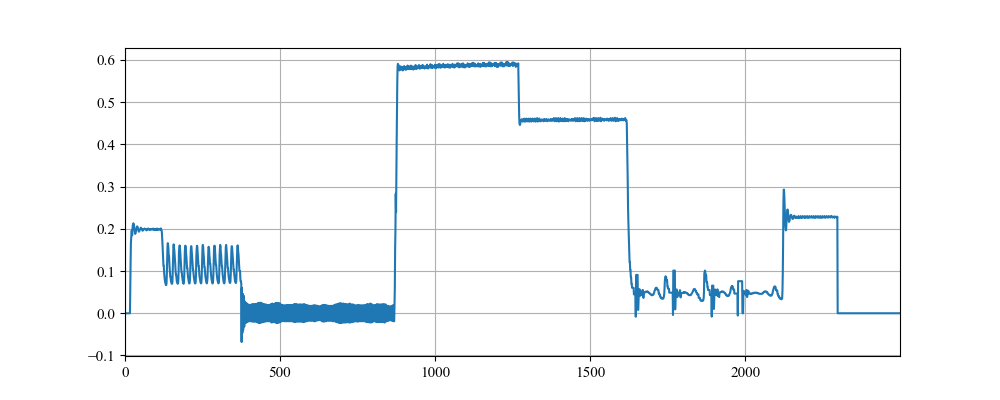

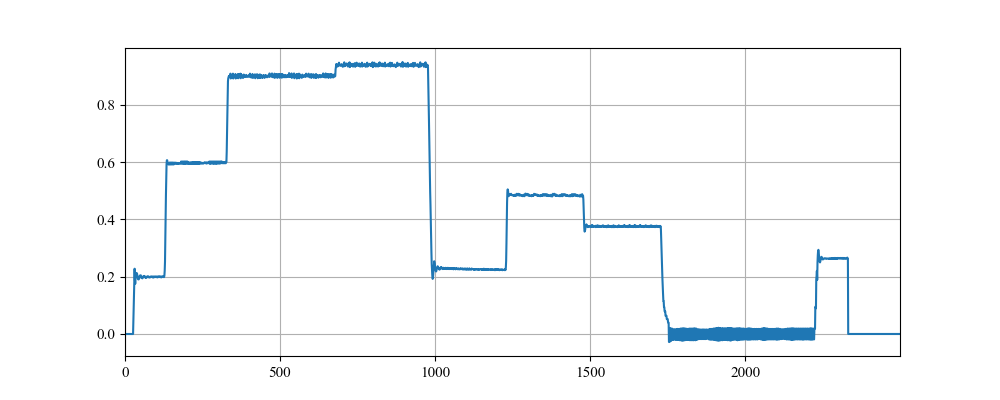

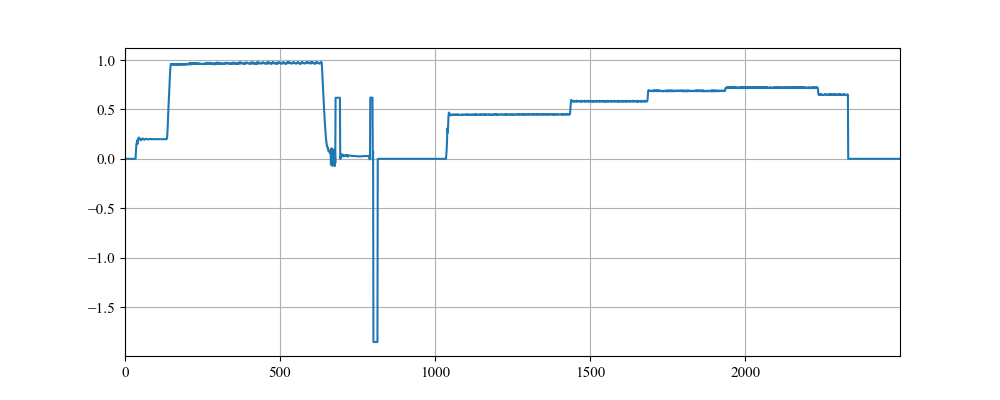

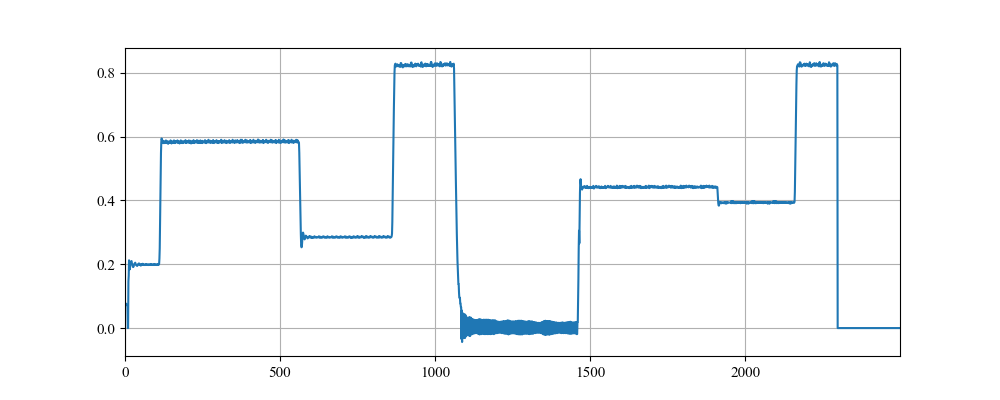

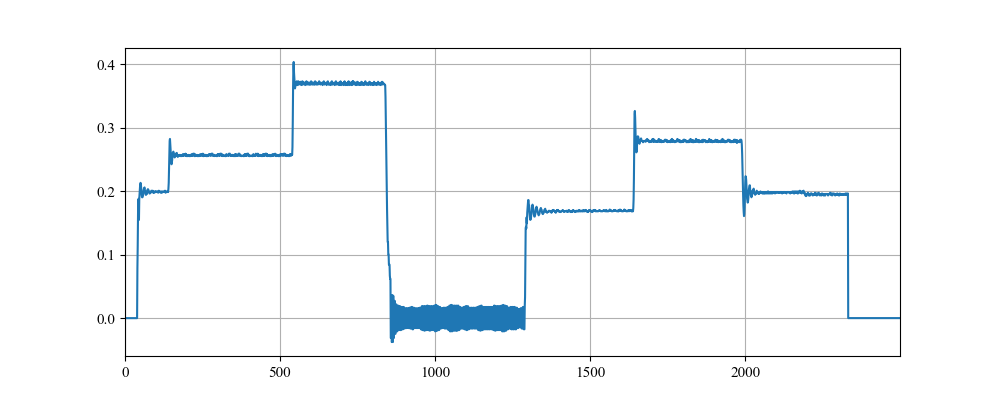

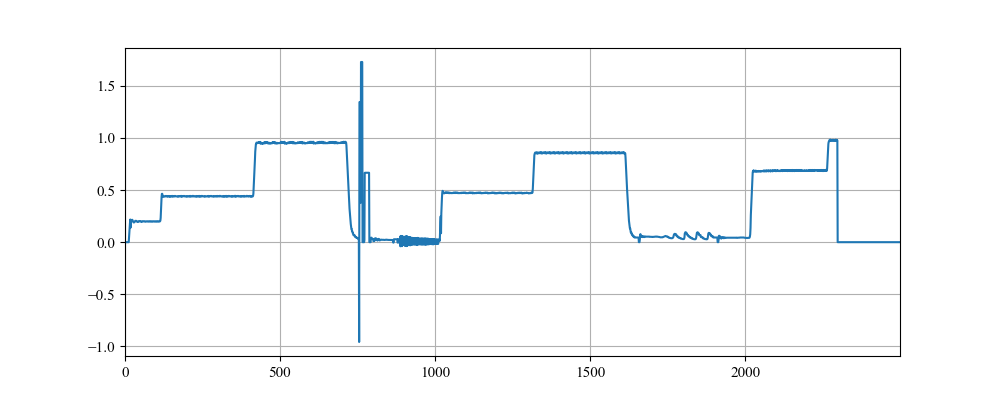

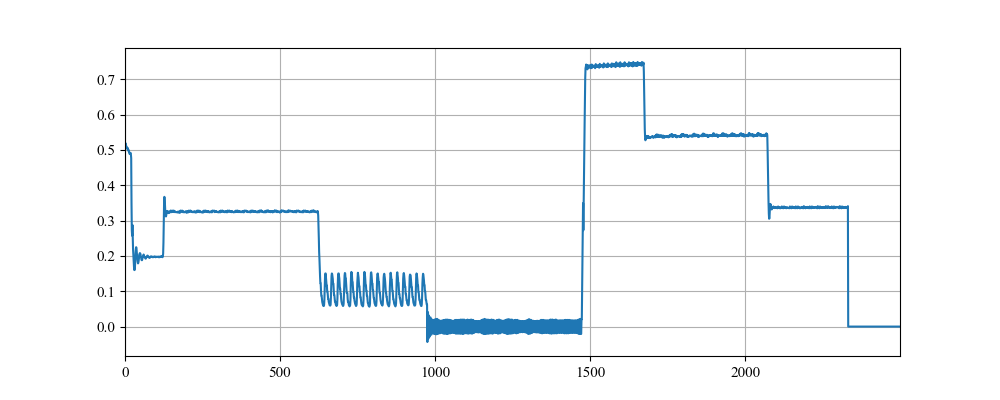

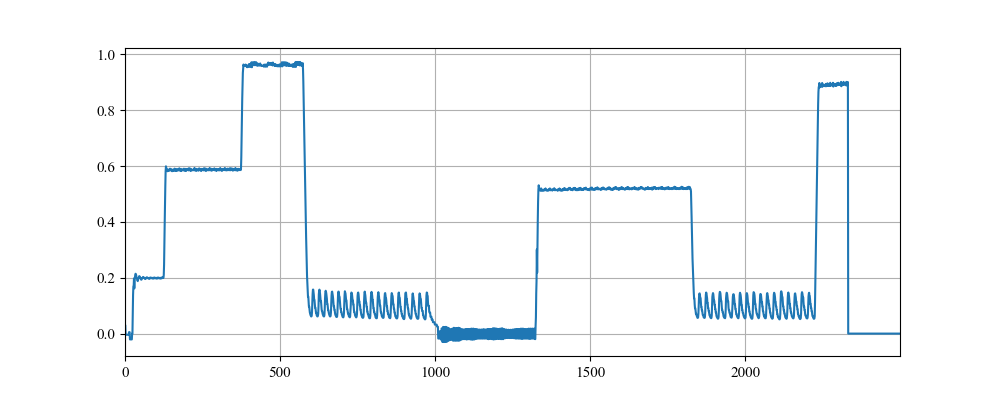

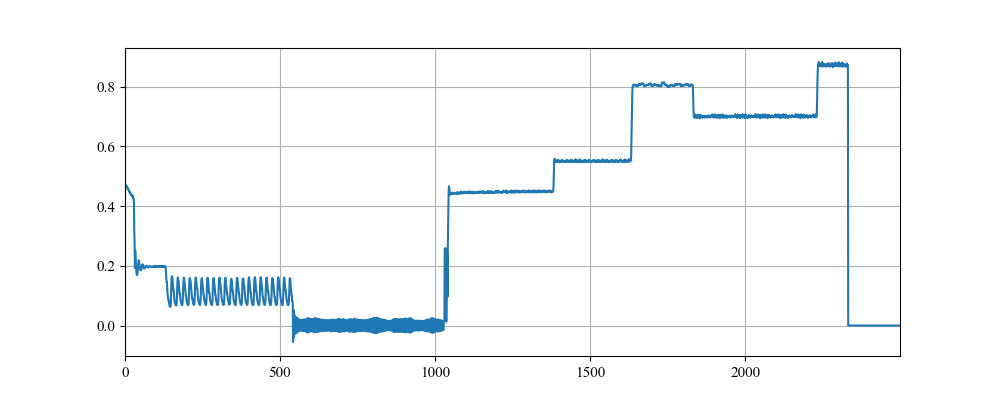

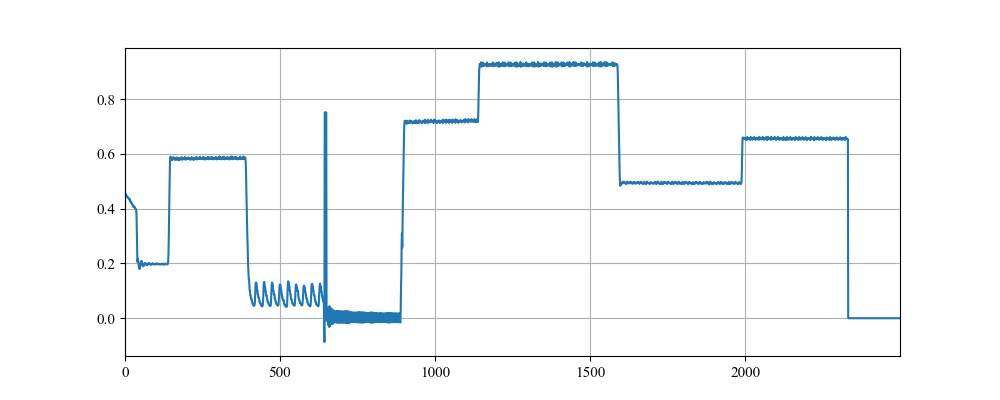

In [28]:
## test each experiment
for i in range(10):
    u_full, y_full = dataset_exp.get_full_experiment(i)
    u_full, y_full = u_full.to(device), y_full.to(device)
    y_full_np = y_full.cpu().numpy()  # Shape (seq_len, 1)
    # print(y_full_np.shape)
    plt.figure(figsize=(10,4))
    plt.plot(y_full_np)
    plt.show()
    